#### 4-1 割引クーポンキャンペーンの効果最大化

cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])


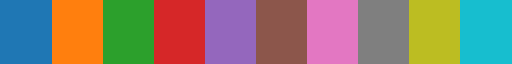

In [1]:
from pulp import LpProblem, LpVariable
from pulp import LpMaximize, LpStatus, lpSum, value
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import math
import seaborn as sns
import time

print(plt.rcParams["axes.prop_cycle"])
plt.get_cmap('tab10')

In [2]:
files = glob('../*/*coupon/*.csv')
dfs = [pd.read_csv(file) for file in files]
for df in dfs:
    display(df.head(3), df.shape)

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0


(5000, 3)

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74


(16, 6)

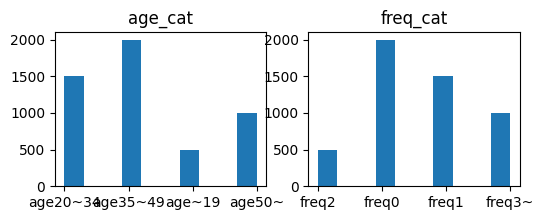

In [3]:
c_df = dfs[0]
fig, axs = plt.subplots(1, 2, figsize=(6, 2))
for i, c in enumerate(c_df.columns[1:]):
    axs[i].hist(c_df[c])
    axs[i].set_title(c)

<Axes: xlabel='freq_cat', ylabel='age_cat'>

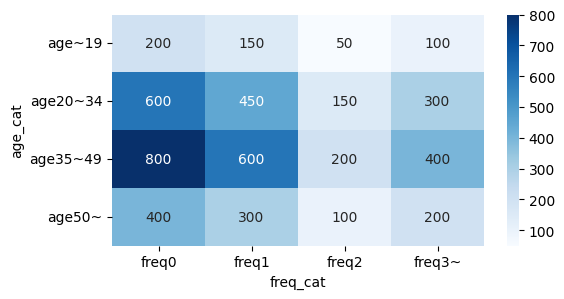

In [4]:
pivot_df = pd.pivot_table(data=c_df, index='age_cat', columns='freq_cat', values='customer_id', aggfunc='count')
pivot_df = pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
plt.figure(figsize=(6, 3))
sns.heatmap(pivot_df, annot=True, fmt='d', cmap='Blues')

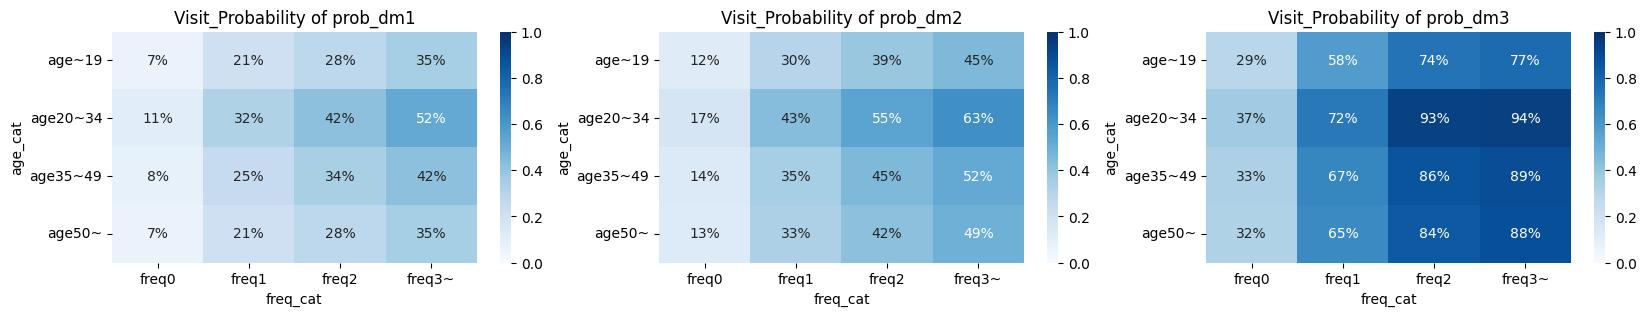

In [5]:
p_df = dfs[1]
fig, axs = plt.subplots(1, 3, figsize=(20, 3))
for i, dm_num in enumerate(['prob_dm1', 'prob_dm2', 'prob_dm3']):
    pivot_df = pd.pivot_table(data=p_df, index='age_cat', columns='freq_cat', values=dm_num)
    pivot_df = pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(pivot_df, vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues', ax=axs[i])
    axs[i].set_title(f'Visit_Probability of {dm_num}')
plt.show()

In [6]:
ID = c_df['customer_id']
DM = [i+1 for i in range(3)]
xim = {(id, dm): LpVariable(name=f'xim({id:03},{dm})', cat='Binary') for dm in DM for id in ID}

In [7]:
c_p_df = pd.merge(c_df, p_df, on=['age_cat', 'freq_cat'])
c_p_var_df = c_p_df.rename(columns={'prob_dm1': 1, 'prob_dm2': 2, 'prob_dm3': 3})
c_p_var_df = c_p_var_df.melt(id_vars=['customer_id'], value_vars=[1, 2, 3], var_name='dm', value_name='prob')
pim = c_p_var_df.set_index(['customer_id', 'dm'])['prob'].to_dict()

In [8]:
cost_dm = {1: 0, 2: 1000, 3: 2000}

In [9]:
SEG = p_df['segment_id']
ns = c_p_df.groupby('segment_id').count()['customer_id'].to_dict()
si = c_p_df.set_index('customer_id')['segment_id'].to_dict()

In [10]:
m = LpProblem('DiscountCouponProblem01', sense=LpMaximize)

for id in ID:
    m += lpSum(xim[id, dm] for dm in DM) == 1

m += lpSum((pim[id, dm] - pim[id, 1]) * xim[id, dm] for id in ID for dm in DM)

m += lpSum(cost_dm[dm] * pim[id, dm] * xim[id, dm] for id in ID for dm in DM) <= 1000000

for s in SEG:
    for dm in DM:
        m += lpSum(xim[id, dm] for id in ID if si[id] == s) >= 0.1 * ns[s]

# m

In [11]:
start = time.time()
status = m.solve()
end = time.time()

In [12]:
print(f'Status: {LpStatus[status]}')
print(f'Result: {value(m.objective):.02f}')
print(f'Time: {end - start:.02f} [sec]')

Status: Optimal
Result: 326.09
Time: 5.56 [sec]


In [22]:
send_dm_df = pd.DataFrame([[xim[id, dm].value() for dm in DM] for id in ID], columns=['send_dm1', 'send_dm2', 'send_dm3'])
cust_send_df = pd.concat([c_df[['customer_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
cust_send_df.head()

,customer_id,age_cat,freq_cat,send_dm1,send_dm2,send_dm3
0,1,age20~34,freq2,0.0,1.0,0.0
1,2,age35~49,freq0,0.0,1.0,0.0
2,3,age35~49,freq0,0.0,1.0,0.0
3,4,age~19,freq0,0.0,1.0,0.0
4,5,age35~49,freq0,0.0,1.0,0.0


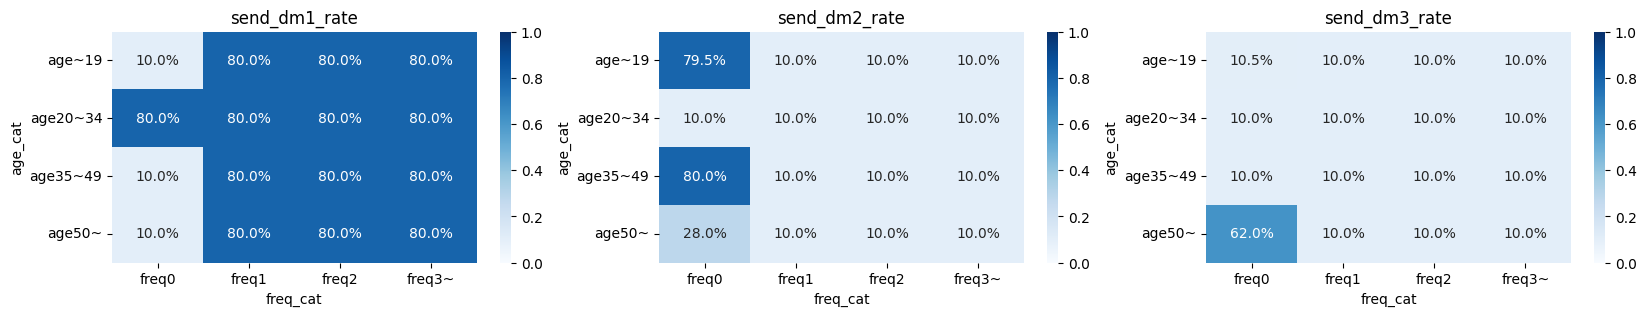

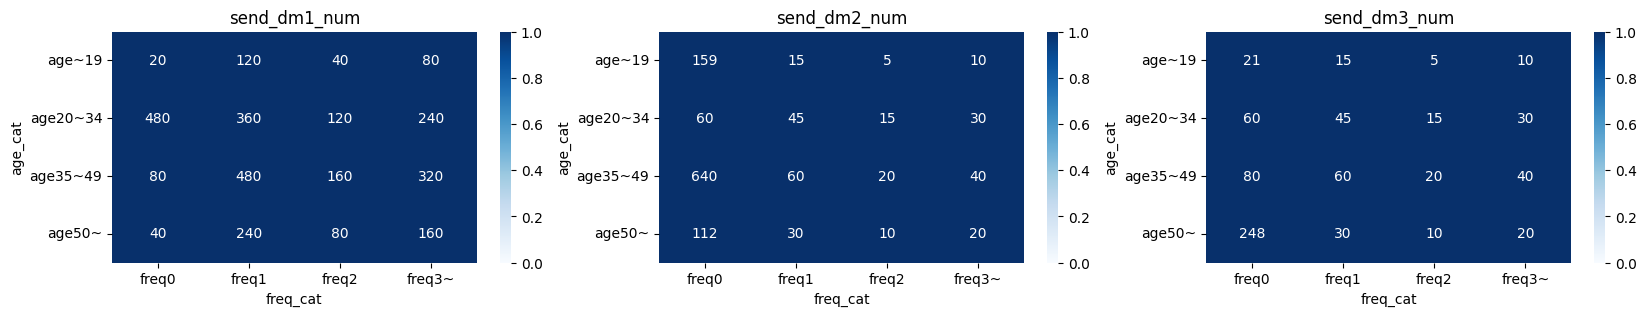

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(20, 3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns='freq_cat', index='age_cat', aggfunc='mean')
    pivot_df = pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(pivot_df, vmin=0, vmax=1, annot=True, fmt='.1%', cmap='Blues', ax=axs[i])
    axs[i].set_title(f'{ptn}_rate')

fig, axs = plt.subplots(1, 3, figsize=(20, 3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns='freq_cat', index='age_cat', aggfunc='sum')
    pivot_df = pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(pivot_df, vmin=0, vmax=1, annot=True, fmt='.0f', cmap='Blues', ax=axs[i])
    axs[i].set_title(f'{ptn}_num')
